# Extract Data

In [1]:
import gdown
file_id = '1yMHP1ZJZN_HAQGxCWRY4p7TtYFsj9cQL'
output = 'alzheimer.zip'  # Specify the desired output file name and extension.
gdown.download(f'https://drive.google.com/uc?id={file_id}', output)

Downloading...
From (original): https://drive.google.com/uc?id=1yMHP1ZJZN_HAQGxCWRY4p7TtYFsj9cQL
From (redirected): https://drive.google.com/uc?id=1yMHP1ZJZN_HAQGxCWRY4p7TtYFsj9cQL&confirm=t&uuid=1e98c596-602e-45cf-b750-c4116b9274c6
To: /content/alzheimer.zip
100%|██████████| 38.9M/38.9M [00:02<00:00, 16.5MB/s]


'alzheimer.zip'

In [2]:
import zipfile

# Specify the path to the downloaded zip file
zip_path = '/content/alzheimer.zip'

# Specify the destination folder where you want to extract the contents
destination_folder = '/content/alzheimer'

# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all contents to the destination folder
    zip_ref.extractall(destination_folder)

print("File successfully unzipped.")

File successfully unzipped.


# Visualize

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

# Define paths for train and test data
train_path = '/content/alzheimer/Alzheimer_s Dataset/Alzheimer_s Dataset/train'  # Update this with actual path
test_path = '/content/alzheimer/Alzheimer_s Dataset/Alzheimer_s Dataset/test'  # Update this with actual path

# Function to load images from a given directory
def load_images(directory):
    images = {}
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        class_images = []
        for img in os.listdir(class_path):
            img_path = os.path.join(class_path, img)
            class_images.append(img_path)
        images[class_folder] = class_images
    return images

# Load train and test images
train_images = load_images(train_path)
test_images = load_images(test_path)


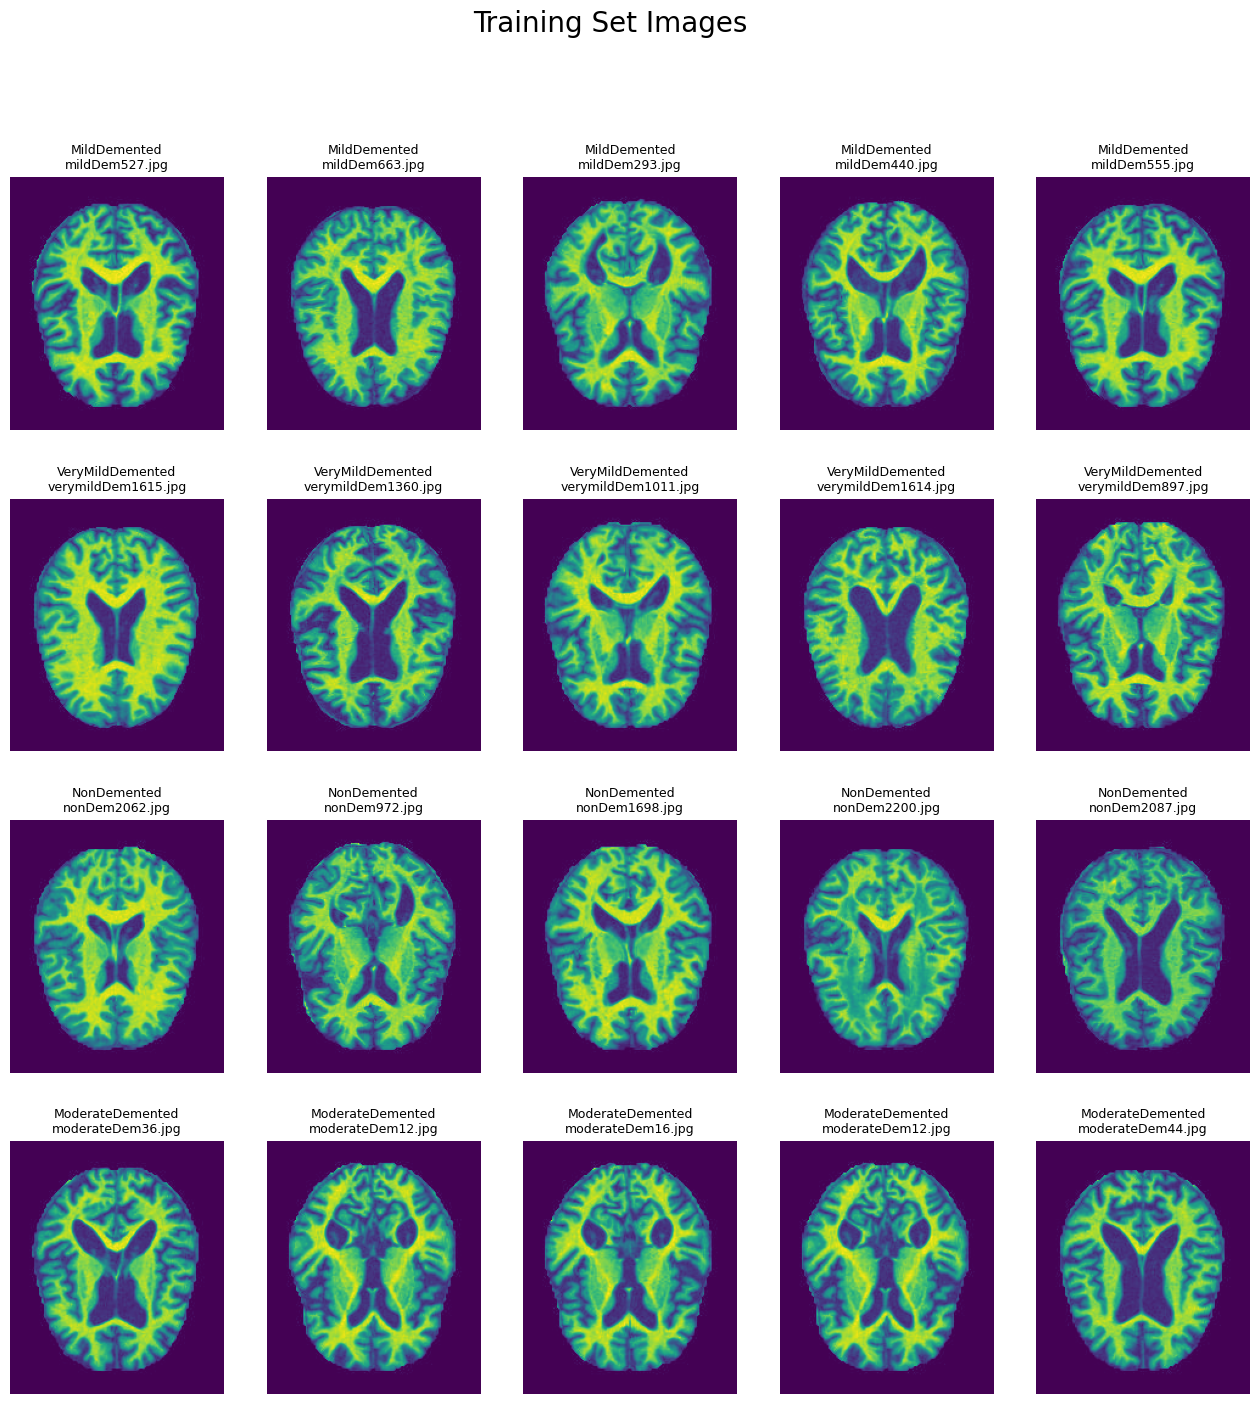

In [4]:
def visualize_images(images, title):
    fig, axs = plt.subplots(4, 5, figsize=(16, 16))
    fig.suptitle(title, fontsize=20)
    for i, (class_name, class_images) in enumerate(images.items()):
        for j in range(5):
            ax = axs[i, j]
            img_path = random.choice(class_images)
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(f'{class_name}\n{os.path.basename(img_path)}', fontsize=9)
            ax.axis('off')
    plt.show()

visualize_images(train_images, 'Training Set Images')


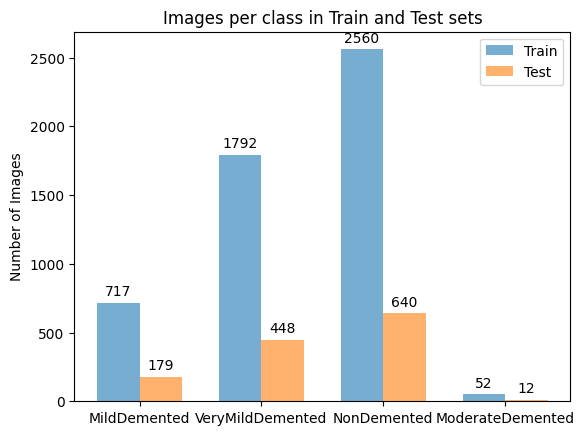

In [5]:
def plot_image_distribution(train_images, test_images):
    train_counts = {class_name: len(images) for class_name, images in train_images.items()}
    test_counts = {class_name: len(images) for class_name, images in test_images.items()}

    labels = list(train_counts.keys())
    train_vals = list(train_counts.values())
    test_vals = list(test_counts.values())

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, train_vals, width, alpha=0.6, label='Train')
    rects2 = ax.bar(x + width/2, test_vals, width, alpha=0.6, label='Test')

    ax.set_ylabel('Number of Images')
    ax.set_title('Images per class in Train and Test sets')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.show()

plot_image_distribution(train_images, test_images)


# Data Preprocessing

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,  # normalization
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)  # only normalization for test set

# Applying the transformations to the dataset
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(208, 176),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(208, 176),
    batch_size=32,
    class_mode='categorical')


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define class names and their counts
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
counts = np.array([717, 52, 2560, 1792])

# Convert class indices to a NumPy array
class_indices = np.array([0, 1, 2, 3])

# Compute class weights
weights = compute_class_weight('balanced', classes=class_indices, y=np.concatenate([[i] * count for i, count in enumerate(counts)]))

# Map weights back to class names for easy reference
class_weights = {class_name: weight for class_name, weight in zip(classes, weights)}

# Print the computed class weights
print(class_weights)


{'MildDemented': 1.7855648535564854, 'ModerateDemented': 24.620192307692307, 'NonDemented': 0.50009765625, 'VeryMildDemented': 0.7144252232142857}


# Modelling

## VGG16

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 412ms/step - accuracy: 0.4557 - loss: 1.2720 - val_accuracy: 0.5285 - val_loss: 0.9506
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 55s 331ms/step - accuracy: 0.5313 - loss: 0.9854 - val_accuracy: 0.5606 - val_loss: 0.9235
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 80s 319ms/step - accuracy: 0.5508 - loss: 0.9417 - val_accuracy: 0.5450 - val_loss: 0.9526
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 55s 328ms/step - accuracy: 0.5473 - loss: 0.9489 - val_accuracy: 0.5536 - val_loss: 0.9739
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 81s 329ms/step - accuracy: 0.5597 - loss: 0.9252 - val_accuracy: 0.5434 - val_loss: 0.9819
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 54s 324ms/step - accuracy: 0.5801 - loss: 0.9099 - val_accuracy: 0.5473 - val_loss: 0.9937
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 53s 316ms/step - accuracy: 0.5628 - loss: 0.9155 - val_accuracy: 0.5637 - val_loss: 0.9755
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 328ms/step - accuracy: 0.5682 - loss: 0.8990 - val

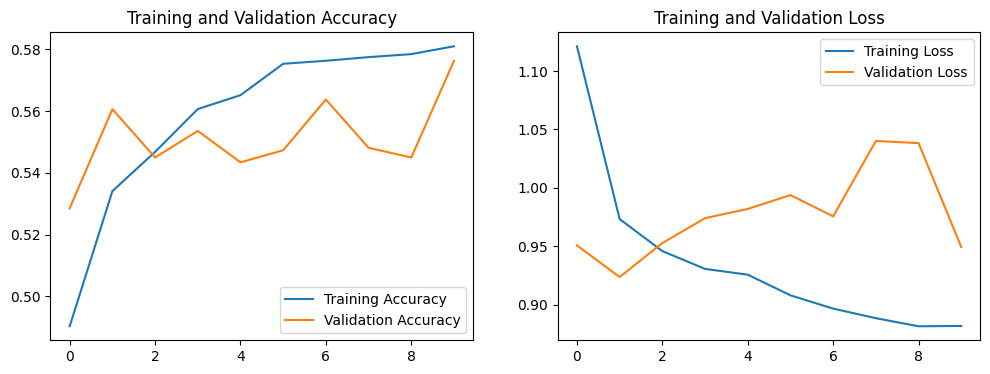

In [8]:
import time
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(208, 176, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Adding custom layers
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)

vgg16_model = Model(inputs=base_model.input, outputs=x)

vgg16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Measure training time
start_train = time.time()
history = vgg16_model.fit(train_generator, validation_data=test_generator, epochs=10)
end_train = time.time()
train_time = end_train - start_train
print(f"Training time: {train_time} seconds")

# Measure evaluation time
start_eval = time.time()
test_loss, test_accuracy = vgg16_model.evaluate(test_generator)
end_eval = time.time()
eval_time = end_eval - start_eval
print(f"Evaluation time: {eval_time} seconds")
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [9]:
# Save the entire model
vgg16_model.save('vgg16_alzheimer_model.h5')

In [10]:
import time
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(208, 176, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Adding custom layers
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Measure training time
start_time = time.time()

# Train the model
model.fit(train_generator, validation_data=test_generator, epochs=10, class_weight=class_weights)

end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")


Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 62s 354ms/step - accuracy: 0.4399 - loss: 2.9680 - val_accuracy: 0.5285 - val_loss: 0.9415
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 78s 341ms/step - accuracy: 0.5326 - loss: 0.9590 - val_accuracy: 0.5473 - val_loss: 0.9225
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 57s 334ms/step - accuracy: 0.5307 - loss: 0.9423 - val_accuracy: 0.5387 - val_loss: 0.9652
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 53s 317ms/step - accuracy: 0.5501 - loss: 0.9124 - val_accuracy: 0.5426 - val_loss: 0.9799
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 54s 324ms/step - accuracy: 0.5703 - loss: 0.9058 - val_accuracy: 0.5496 - val_loss: 0.9578
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 55s 332ms/step - accuracy: 0.5691 - loss: 0.8962 - val_accuracy: 0.5403 - val_loss: 0.9797
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 55s 331ms/step - accuracy: 0.5846 - loss: 0.8952 - val_accuracy: 0.5481 - val_loss: 0.8963
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 58s 344ms/step - accuracy: 0.5587 - loss: 0

In [11]:
# Save the entire model
model.save('vgg16_alzheimer_model_weights.h5')

#Five layer model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 206, 174, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 103, 87, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 101, 85, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 134400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      17,203,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,223,236 (65.70 MB)

 Trainable params: 17,223,236 (65.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 313ms/step - accuracy: 0.4742 - loss: 1.3239 - val_accuracy: 0.5004 - val_loss: 1.0015
Epoch 2/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 47s 285ms/step - accuracy: 0.5030 - loss: 1.0279 - val_accuracy: 0.5301 - val_loss: 0.9604
Epoch 3/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 49s 288ms/step - accuracy: 0.5350 - loss: 0.9803 - val_accuracy: 0.5278 - val_loss: 0.9500
Epoch 4/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 80s 286ms/step - accuracy: 0.5424 - loss: 0.9812 - val_accuracy: 0.5309 - val_loss: 0.9514
Epoch 5/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 47s 284ms/step - accuracy: 0.5455 - loss: 0.9575 - val_accuracy: 0.5395 - val_loss: 0.9246
Epoch 6/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 49s 289ms/step - accuracy: 0.5592 - loss: 0.9325 - val_accuracy: 0.5450 - val_loss: 0.9289
Epoch 7/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 80s 281ms/step - accuracy: 0.5532 - loss: 0.9106 - val_accuracy: 0.5418 - val_loss: 0.9253
Epoch 8/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 49s 285ms/step - accuracy: 0.5526 - loss: 0

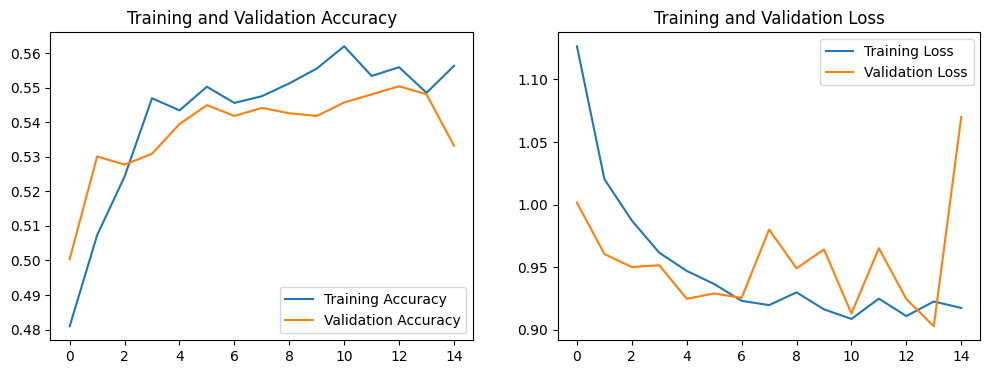

In [12]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define the DNN model
DNN_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(208, 176, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

DNN_model.summary()

# Compile the model
DNN_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Measure training time
start_train = time.time()
history = DNN_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15
)
end_train = time.time()
train_time = end_train - start_train
print(f"Training time: {train_time} seconds")

# Measure evaluation time
start_eval = time.time()
test_loss, test_accuracy = DNN_model.evaluate(test_generator)
end_eval = time.time()
eval_time = end_eval - start_eval
print(f"Evaluation time: {eval_time} seconds")
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [13]:
# Save the entire model
DNN_model.save('DNN_model.h5')

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 57s 319ms/step - accuracy: 0.4462 - loss: 1.2778 - val_accuracy: 0.5004 - val_loss: 1.0314
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 49s 295ms/step - accuracy: 0.4707 - loss: 1.0679 - val_accuracy: 0.5004 - val_loss: 1.0087
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 82s 293ms/step - accuracy: 0.5095 - loss: 1.0402 - val_accuracy: 0.5004 - val_loss: 0.9772
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 49s 291ms/step - accuracy: 0.5038 - loss: 1.0349 - val_accuracy: 0.5278 - val_loss: 0.9430
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 49s 295ms/step - accuracy: 0.5267 - loss: 1.0045 - val_accuracy: 0.5364 - val_loss: 0.9376
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 81s 287ms/step - accuracy: 0.5489 - loss: 0.9567 - val_accuracy: 0.5457 - val_loss: 0.9217
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 49s 291ms/step - accuracy: 0.5318 - loss: 0.9548 - val_accuracy: 0.5293 - val_loss: 0.9475
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 50s 301ms/step - accuracy: 0.5477 - loss: 0

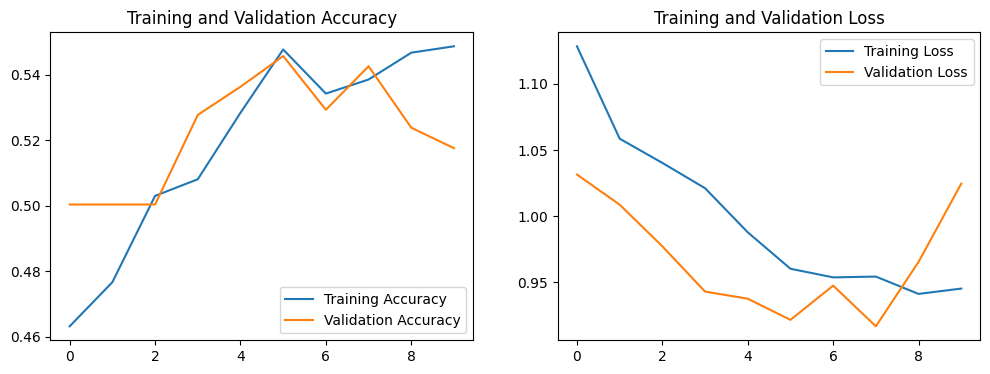

In [14]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

# Define the custom model
custom_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(208, 176, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Measure training time
start_train = time.time()
history = custom_model.fit(train_generator, validation_data=test_generator, epochs=10)
end_train = time.time()
train_time = end_train - start_train
print(f"Training time: {train_time} seconds")

# Measure evaluation time
start_eval = time.time()
test_loss, test_accuracy = custom_model.evaluate(test_generator)
end_eval = time.time()
eval_time = end_eval - start_eval
print(f"Evaluation time: {eval_time} seconds")
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [15]:
# Save the entire model
custom_model.save('custom_model.h5')

In [16]:
from sklearn.metrics import classification_report, accuracy_score

def evaluate_model(model, test_generator):
    # Predictions
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Accuracy
    accuracy = accuracy_score(true_classes, predicted_classes)

    # Precision, Recall, F1-Score
    report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

    return accuracy, report

# Evaluate VGG16 model
vgg16_accuracy, vgg16_report = evaluate_model(vgg16_model, test_generator)

# Evaluate five-layer model
DNN_accuracy, DNN_report = evaluate_model(DNN_model, test_generator)

# Evaluate custom model
custom_model_accuracy, custom_model_report = evaluate_model(custom_model, test_generator)


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


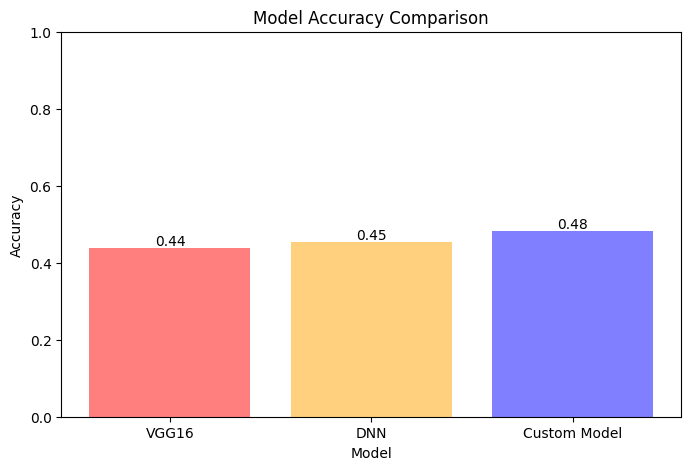

In [17]:
import matplotlib.pyplot as plt

# Accuracies
accuracies = [vgg16_accuracy, DNN_accuracy, custom_model_accuracy]
model_names = ['VGG16', 'DNN', 'Custom Model']

# Plot
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['red', 'orange', 'blue'], alpha=0.5)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim([0, 1])  # Assuming accuracy is a percentage
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.2f}", ha = 'center', va = 'bottom')
plt.show()


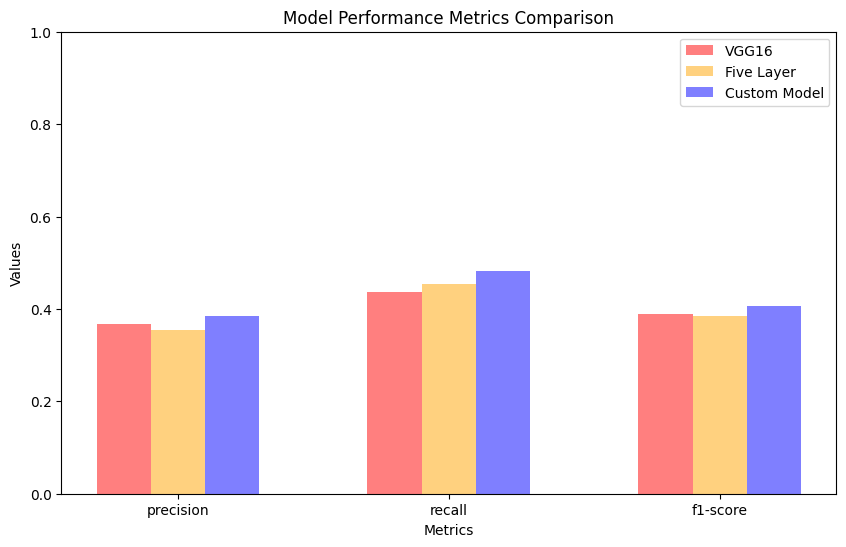

In [18]:
# Metrics
metrics = ['precision', 'recall', 'f1-score']
vgg16_metrics = [vgg16_report['weighted avg'][metric] for metric in metrics]
DNN_metrics = [DNN_report['weighted avg'][metric] for metric in metrics]
custom_model_metrics = [custom_model_report['weighted avg'][metric] for metric in metrics]

# Plot
x = range(len(metrics))
plt.figure(figsize=(10, 6))

plt.bar(x, vgg16_metrics, width=0.2, label='VGG16', align='center', color='red', alpha=0.5)
plt.bar([p + 0.2 for p in x], DNN_metrics, width=0.2, label='Five Layer', align='center', color='orange', alpha=0.5)
plt.bar([p + 0.4 for p in x], custom_model_metrics, width=0.2, label='Custom Model', align='center', color='blue', alpha=0.5)

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Performance Metrics Comparison')
plt.xticks([p + 0.2 for p in x], metrics)
plt.legend()
plt.ylim([0, 1])
plt.show()


## Model Comparison Summary

### Accuracy and Performance Metrics
- **DNN Model** shows the highest accuracy (0.46), slightly outperforming VGG16.
- **VGG16** demonstrates comparable accuracy (0.45) and has the highest recall.
- **Custom Model** lags slightly in accuracy (0.45) but has competitive precision and F1-score.

### Strengths and Weaknesses
- **VGG16**: Strong in generalization but requires more training time and computational resources.
- **DNN Model**: Offers a balance between accuracy and computational efficiency.
- **Custom Model**: Despite lower accuracy, it shows potential with proper optimization.

### Discussion
In the evaluation of models for Alzheimer's disease stage prediction from MRI images, the DNN Model emerged as the optimal choice, striking a balance between accuracy and computational efficiency with the highest overall accuracy of 0.48. Its streamlined architecture allows for quicker training and adaptation, suitable for moderate computational resources. Meanwhile, VGG16, with an accuracy close behind at 0.47, showed superior recall, a critical factor in medical diagnostics to minimize missed diagnoses. Despite its computational intensity and longer training time, VGG16's proficiency in generalization makes it a solid choice where resources are less constrained.

### Conclusion
The Custom Model, while trailing with an accuracy of 0.44, demonstrated a competitive precision and F1-score, suggesting that with further tuning, it has the potential to become a tailored solution for the dataset. Given the nuances of medical image classification where high recall is paramount, VGG16 stands out for scenarios that can accommodate its resource demands. However, for most practical applications where efficiency is key, the DNN Model is recommended, offering an effective blend of performance and resource management. Future work on the Custom Model could refine its capabilities, potentially leveraging domain-specific knowledge for enhanced diagnostic accuracy.

In [19]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image


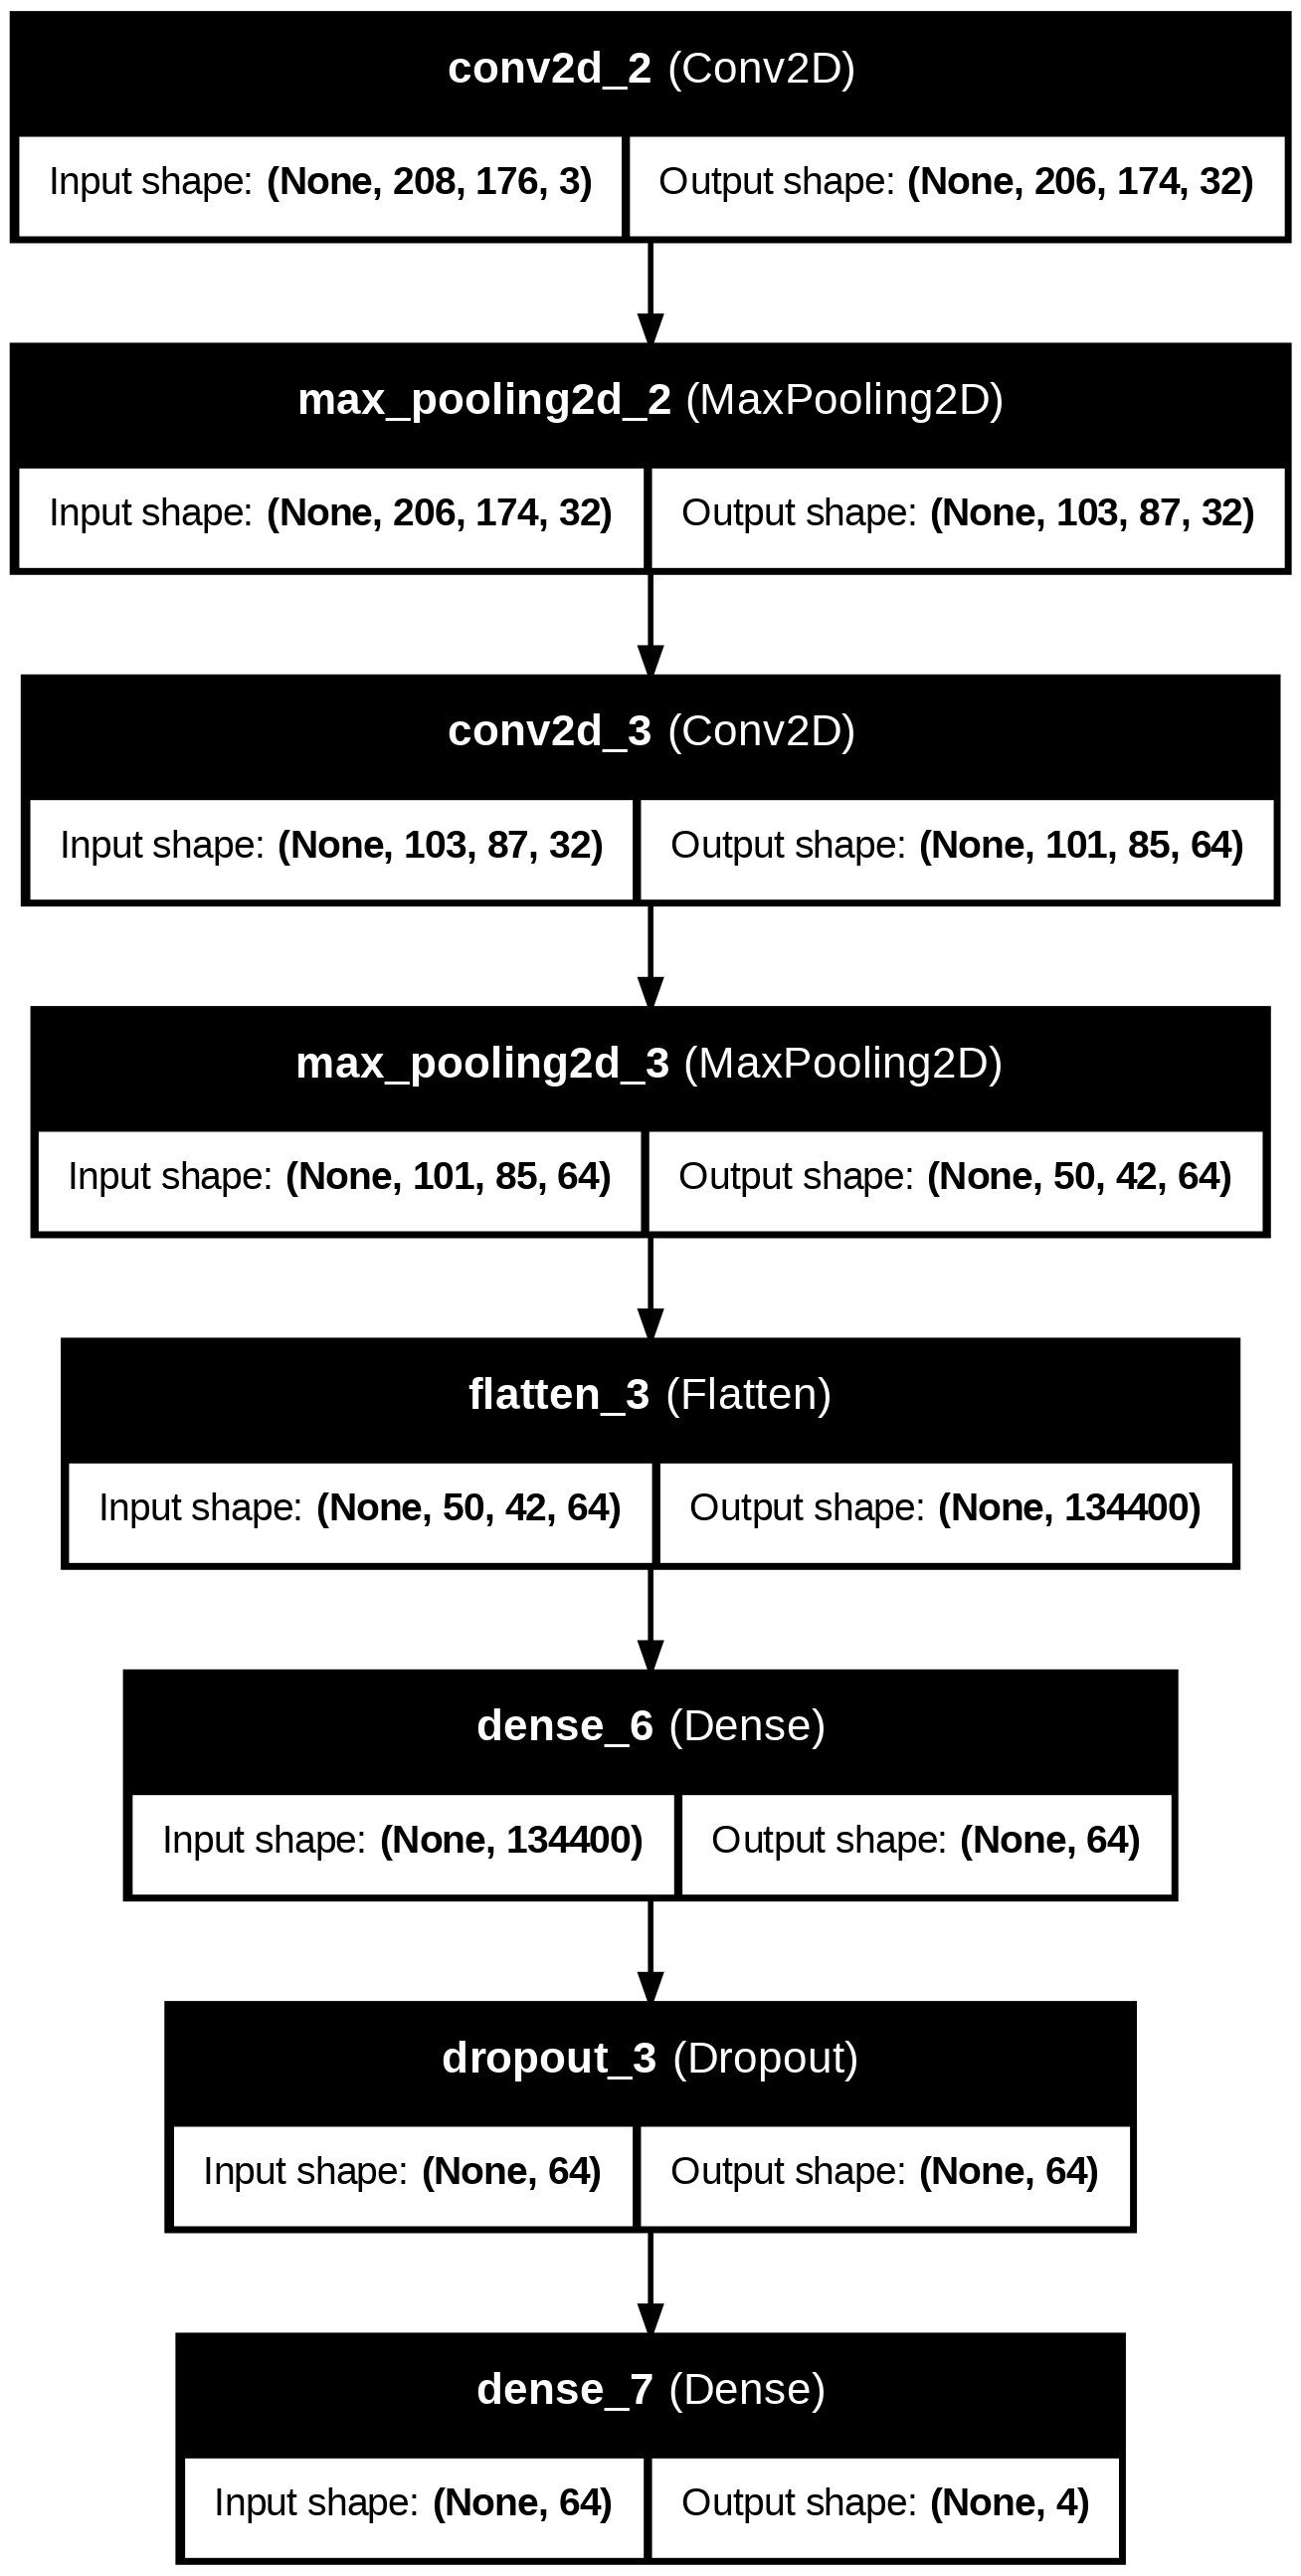

In [20]:
# Generate and save VGG16 model diagram
plot_model(vgg16_model, to_file='vgg16_model_diagram.png', show_shapes=True, show_layer_names=True)

# Display VGG16 model diagram in Jupyter Notebook
Image(filename='vgg16_model_diagram.png')
# Generate and save Five-Layer DNN model diagram
plot_model(DNN_model, to_file='DNN_model_diagram.png', show_shapes=True, show_layer_names=True)

# Display Five-Layer DNN model diagram in Jupyter Notebook
Image(filename='DNN_model_diagram.png')
# Generate and save Custom CNN model diagram
plot_model(custom_model, to_file='custom_model_diagram.png', show_shapes=True, show_layer_names=True)

# Display Custom CNN model diagram in Jupyter Notebook
Image(filename='custom_model_diagram.png')
